# Version Note:

Source: https://www.kaggle.com/code/dwin183287/tps-jan-2021-eda-models

In [1]:
import os
import joblib
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import auc
from sklearn.model_selection import cross_val_score, cross_val_predict,RandomizedSearchCV, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

import optuna

In [2]:
train_df = pd.read_csv('../input/hyperspectral-classification-ii/train_without_leak.csv')
test_df = pd.read_csv('../input/hyperspectral-classification-ii/test_without_leak.csv')
submission = pd.read_csv('../input/hyperspectral-classification-ii/sample_submission_without_leak.csv')

In [3]:
features = [feature for feature in train_df.columns if feature not in ['pixel_id', 'target']]
X_train = train_df[features]
y_train = train_df['target']
X_test = test_df[features]

In [4]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler

In [5]:
oversample = SMOTE(random_state=0)
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

In [6]:
downsample = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = downsample.fit_resample(X_train, y_train)

In [7]:
y_train_rus.value_counts()

0.0    29
1.0    29
2.0    29
Name: target, dtype: int64

In [8]:
y_train_smote.value_counts()

0.0    6074
1.0    6074
2.0    6074
Name: target, dtype: int64

In [9]:
print('Rows and Columns in train dataset:', train_df.shape)
print('Rows and Columns in test dataset:', test_df.shape)

Rows and Columns in train dataset: (6132, 362)
Rows and Columns in test dataset: (6132, 361)


In [10]:
print('First 5 data in the train dataset:')
train_df.head()

First 5 data in the train dataset:


,pixel_id,band1,band2,band3,band4,band5,band6,band7,band8,band9,...,band352,band353,band354,band355,band356,band357,band358,band359,band360,target
0,0,0.099898,0.100479,0.104012,0.108699,0.113932,0.117117,0.118139,0.118768,0.118964,...,-0.321490,-0.455935,-0.467314,-0.123038,0.215500,0.501770,0.253342,0.148561,-0.021121,0.0
1,1,0.116952,0.116431,0.117600,0.117725,0.117042,0.113959,0.115088,0.116210,0.118767,...,-0.255321,-0.368646,-0.393768,-0.081815,0.233525,0.526591,0.377525,0.336791,0.198253,0.0
2,2,0.108681,0.109839,0.113774,0.117101,0.119068,0.120834,0.121657,0.121627,0.121650,...,-0.600094,-0.757896,-0.711437,-0.289917,0.168186,0.627783,0.482006,0.383744,0.207901,0.0
3,3,0.127586,0.120198,0.114211,0.110567,0.109458,0.112735,0.118176,0.119415,0.121006,...,-0.105756,-0.119838,-0.210905,0.143527,0.441095,0.709301,0.618201,0.509158,0.368789,0.0
4,4,0.095347,0.095927,0.098766,0.103254,0.109537,0.115701,0.123573,0.126196,0.124234,...,-0.160474,-0.226066,-0.335191,0.154934,0.598158,0.869417,0.712456,0.529970,0.238561,0.0


In [11]:
print('First 5 data in the test dataset:')
test_df.head()

First 5 data in the test dataset:


,pixel_id,band1,band2,band3,band4,band5,band6,band7,band8,band9,...,band351,band352,band353,band354,band355,band356,band357,band358,band359,band360
0,0,0.133389,0.129491,0.126459,0.124272,0.124178,0.126550,0.127879,0.128428,0.129753,...,-0.110739,-0.211382,-0.335115,-0.479695,0.006043,0.436961,0.765480,0.724100,0.705523,0.524162
1,1,0.128174,0.128466,0.129490,0.129316,0.127310,0.123222,0.125130,0.124590,0.124309,...,-0.192084,-0.356316,-0.493620,-0.511466,-0.215836,0.122240,0.427564,0.371376,0.209782,0.018533
2,2,0.130374,0.128294,0.127120,0.125729,0.125745,0.123653,0.125633,0.128435,0.128574,...,-0.146008,-0.232602,-0.297574,-0.343908,0.014260,0.327855,0.601620,0.573348,0.525252,0.387948
3,3,0.116920,0.111982,0.110926,0.113348,0.117537,0.123360,0.130536,0.132629,0.131570,...,-0.155472,-0.254321,-0.352334,-0.438248,-0.018240,0.338860,0.655980,0.591076,0.555939,0.409419
4,4,0.122099,0.120759,0.121411,0.123659,0.127483,0.131937,0.133688,0.132425,0.130738,...,-0.253065,-0.334190,-0.418588,-0.453047,-0.174258,0.135369,0.462718,0.414162,0.426901,0.412649


In [12]:
print('Missing value in train dataset:', sum(train_df.isnull().sum()))
print('Missing value in test dataset:', sum(test_df.isnull().sum()))

Missing value in train dataset: 0
Missing value in test dataset: 0


In [13]:
print('Statistics on Train dataset')
train_df.describe()

Statistics on Train dataset


,pixel_id,band1,band2,band3,band4,band5,band6,band7,band8,band9,...,band352,band353,band354,band355,band356,band357,band358,band359,band360,target
count,6132.000000,6132.000000,6132.000000,6132.000000,6132.000000,6132.000000,6132.000000,6132.000000,6132.000000,6132.000000,...,6132.000000,6132.000000,6132.000000,6132.000000,6132.000000,6132.000000,6132.000000,6132.000000,6132.000000,6132.000000
mean,3065.500000,0.075330,0.073588,0.073444,0.073311,0.074133,0.074820,0.077431,0.077625,0.077975,...,-0.506421,-0.661588,-0.694983,-0.288007,0.142555,0.568806,0.544273,0.427080,0.252980,0.014188
std,1770.300257,0.045787,0.045573,0.045861,0.046715,0.047656,0.048495,0.049126,0.049798,0.050421,...,0.351728,0.427773,0.451036,0.285710,0.149101,0.179060,0.191623,0.164370,0.151557,0.153131
min,0.000000,-0.040960,-0.035109,-0.032527,-0.030980,-0.025551,-0.020990,-0.015994,-0.014670,-0.013370,...,-1.531799,-1.884109,-1.960408,-1.183417,-0.370799,-0.178498,-0.303005,-0.180396,-0.281824,0.000000
25%,1532.750000,0.046726,0.044999,0.042311,0.038552,0.035679,0.033688,0.035006,0.033795,0.032847,...,-0.725215,-0.932132,-0.989721,-0.469026,0.040421,0.461014,0.422895,0.323934,0.158634,0.000000
50%,3065.500000,0.069249,0.066556,0.067095,0.068278,0.070536,0.072083,0.075147,0.075668,0.076249,...,-0.494714,-0.646262,-0.682090,-0.279609,0.141783,0.581617,0.560361,0.436014,0.248939,0.000000
75%,4598.250000,0.109352,0.108719,0.110035,0.111325,0.113196,0.114873,0.118144,0.118719,0.119445,...,-0.301852,-0.415225,-0.426901,-0.110821,0.242785,0.691797,0.680358,0.537995,0.341676,0.000000
max,6131.000000,0.406770,0.404988,0.411459,0.421906,0.438102,0.457020,0.472306,0.480699,0.489834,...,1.152352,1.331175,1.327365,1.022704,0.743773,1.067587,1.125889,1.016698,0.981617,2.000000


In [14]:
print('Statistics on Test dataset')
test_df.describe()

Statistics on Test dataset


,pixel_id,band1,band2,band3,band4,band5,band6,band7,band8,band9,...,band351,band352,band353,band354,band355,band356,band357,band358,band359,band360
count,6132.000000,6132.000000,6132.000000,6132.000000,6132.000000,6132.000000,6132.000000,6132.000000,6132.000000,6132.000000,...,6132.000000,6132.000000,6132.000000,6132.000000,6132.000000,6132.000000,6132.000000,6132.000000,6132.000000,6132.000000
mean,3065.500000,0.054690,0.052678,0.052155,0.051545,0.051961,0.052236,0.054572,0.054464,0.054626,...,-0.468838,-0.714221,-0.900777,-0.931114,-0.442336,0.076535,0.611655,0.618039,0.504685,0.331072
std,1770.300257,0.048157,0.047140,0.046500,0.046493,0.046837,0.047507,0.048083,0.048738,0.049340,...,0.307334,0.419549,0.500634,0.517352,0.331038,0.158493,0.177893,0.190719,0.169980,0.176431
min,0.000000,-0.040616,-0.036327,-0.029601,-0.024035,-0.020758,-0.018984,-0.014286,-0.014298,-0.013908,...,-1.118433,-1.552332,-1.874039,-1.938426,-1.127865,-0.398156,-0.081663,-0.181308,-0.175215,-0.205007
25%,1532.750000,0.023105,0.022835,0.024281,0.024808,0.025793,0.025408,0.026646,0.025249,0.024341,...,-0.700998,-1.030252,-1.275544,-1.318085,-0.692783,-0.032296,0.503813,0.503097,0.397993,0.207974
50%,3065.500000,0.045720,0.042165,0.040318,0.038111,0.037834,0.037743,0.040244,0.040207,0.040424,...,-0.555682,-0.837516,-1.055440,-1.093376,-0.532563,0.062703,0.629938,0.644111,0.508022,0.308452
75%,4598.250000,0.079325,0.075839,0.074705,0.073529,0.073053,0.072262,0.074064,0.073720,0.074201,...,-0.235136,-0.392597,-0.524664,-0.539762,-0.200091,0.175543,0.734123,0.753124,0.618123,0.433732
max,6131.000000,0.448911,0.434516,0.443406,0.473379,0.508095,0.545052,0.569155,0.585742,0.599059,...,0.808790,0.981209,1.271875,1.365891,1.037922,0.680037,1.126296,1.137589,1.033350,0.916004


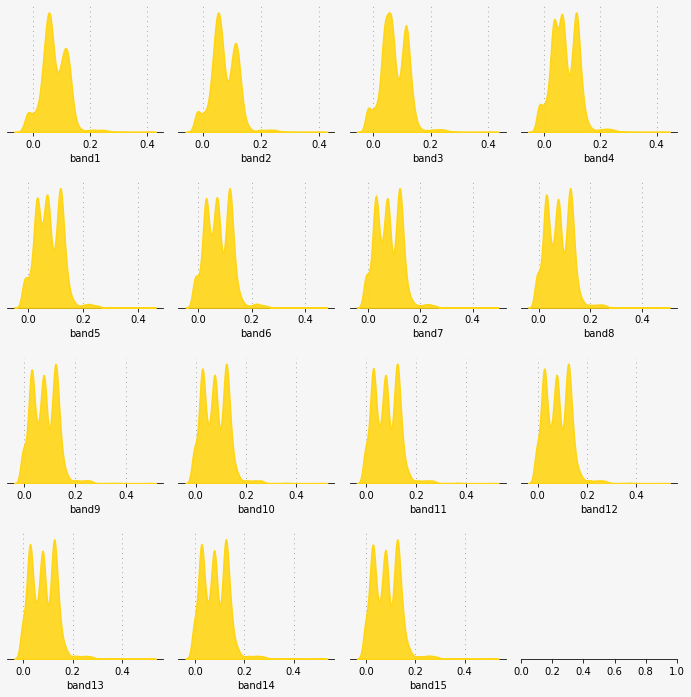

In [15]:
fig = plt.figure(figsize=(12, 12), facecolor='#f6f6f6')
gs = fig.add_gridspec(4, 4)
gs.update(wspace=0.1, hspace=0.4)

background_color = "#f6f6f6"

run_no = 0
for row in range(0, 4):
    for col in range(0, 4):
        locals()["ax"+str(run_no)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(run_no)].set_facecolor(background_color)
        locals()["ax"+str(run_no)].tick_params(axis='y', left=False)
        locals()["ax"+str(run_no)].get_yaxis().set_visible(False)
        for s in ["top","right","left"]:
            locals()["ax"+str(run_no)].spines[s].set_visible(False)
        run_no += 1

run_no = 0
for feature in features[0:15]:
        sns.kdeplot(train_df[feature] ,ax=locals()["ax"+str(run_no)], color='#ffd514', shade=True, linewidth=1.5, alpha=0.9, zorder=3, legend=False)
        locals()["ax"+str(run_no)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
        locals()["ax"+str(run_no)].set_xlabel(feature)
        run_no += 1
        


Text(0.5, 0, 'target')

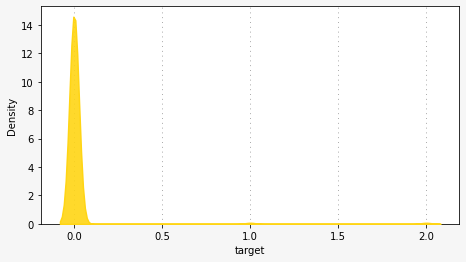

In [16]:
fig = plt.figure(figsize=(7.5, 4), facecolor='#f6f6f6')
gs = fig.add_gridspec(1, 1)
ax0 = fig.add_subplot(gs[0, 0])
sns.kdeplot(train_df['target'], ax=ax0, color='#ffd514', shade=True, linewidth=1.5, alpha=0.9, zorder=3, legend=False)
ax0.grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
ax0.set_xlabel('target')



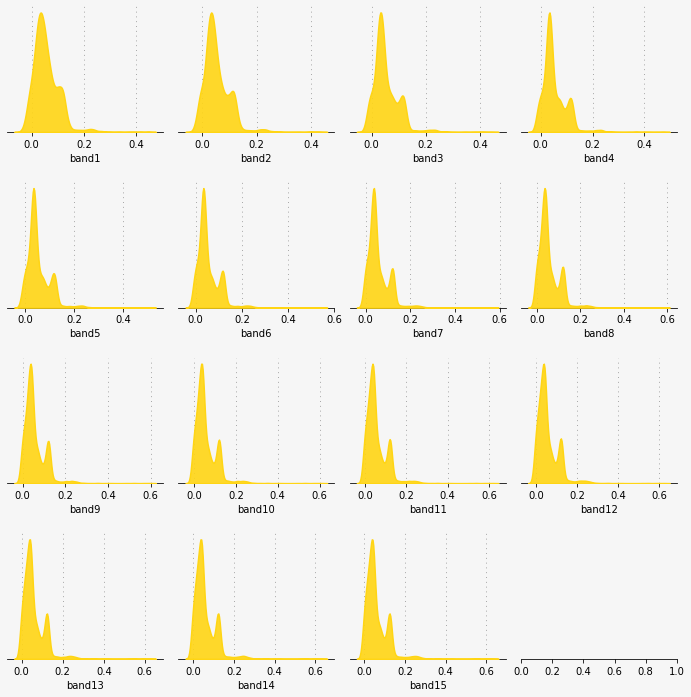

In [17]:
fig = plt.figure(figsize=(12, 12), facecolor='#f6f6f6')
gs = fig.add_gridspec(4, 4)
gs.update(wspace=0.1, hspace=0.4)

background_color = "#f6f6f6"

run_no = 0
for row in range(0, 4):
    for col in range(0, 4):
        locals()["ax"+str(run_no)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(run_no)].set_facecolor(background_color)
        locals()["ax"+str(run_no)].tick_params(axis='y', left=False)
        locals()["ax"+str(run_no)].get_yaxis().set_visible(False)
        for s in ["top","right","left"]:
            locals()["ax"+str(run_no)].spines[s].set_visible(False)
        run_no += 1

run_no = 0
for feature in features[0:15]:
        sns.kdeplot(test_df[feature] ,ax=locals()["ax"+str(run_no)], color='#ffd514', shade=True, linewidth=1.5, alpha=0.9, zorder=3, legend=False)
        locals()["ax"+str(run_no)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
        locals()["ax"+str(run_no)].set_xlabel(feature)
        run_no += 1
        


<a id="simple_models"></a>
# 4. Simple Models


<a id="random_forest"></a>
## Random Forest

In [18]:
%%time
forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train_rus, y_train_rus)

CPU times: user 181 ms, sys: 2.9 ms, total: 183 ms
Wall time: 184 ms


RandomForestClassifier(random_state=42)

In [19]:
output = forest_clf.predict(X_test)
print(output)

[0. 0. 0. ... 0. 0. 0.]


In [20]:
pd.DataFrame(output).rename(columns={0: 'target'}).to_csv('submission_RF_rus.csv', index_label='pixel_id')

In [21]:
M = confusion_matrix(forest_clf.predict(X_train_rus), y_train_rus)
print(M)

[[29  0  0]
 [ 0 29  0]
 [ 0  0 29]]


<a id="lgbm"></a>
## LGBM

In [22]:
%%time
lgbm_clf = LGBMClassifier(random_state=42)
lgbm_clf.fit(X_train_rus, y_train_rus)

output_lgbm = lgbm_clf.predict(X_test)
print(output_lgbm)


[0. 0. 0. ... 0. 0. 0.]
CPU times: user 818 ms, sys: 24.4 ms, total: 842 ms
Wall time: 247 ms


In [23]:
pd.DataFrame(output_lgbm).rename(columns={0: 'target'}).to_csv('submission_lgbm_rus.csv', index_label='pixel_id')

In [24]:
M = confusion_matrix(lgbm_clf.predict(X_train_rus), y_train_rus)
print(M)

[[29  0  0]
 [ 0 29  0]
 [ 0  0 29]]


<a id="xgboost"></a>
## XGBoost

In [25]:
%%time
xgb_clf = XGBClassifier(random_state=42)
xgb_clf.fit(X_train_rus, y_train_rus)

output_xgb = xgb_clf.predict(X_test)
print(output_xgb)


[0 0 0 ... 0 0 0]
CPU times: user 1.89 s, sys: 11 ms, total: 1.9 s
Wall time: 508 ms


In [26]:
pd.DataFrame(output_xgb).rename(columns={0: 'target'}).to_csv('submission_xgb_rus.csv', index_label='pixel_id')

In [27]:
M = confusion_matrix(xgb_clf.predict(X_train_rus), y_train_rus)
print(M)

[[29  0  0]
 [ 0 29  0]
 [ 0  0 29]]


<a id="catboost"></a>
## CatBoost

In [28]:
%%time
cb_clf = CatBoostClassifier(random_state=42, verbose=False)
cb_clf.fit(X_train_rus, y_train_rus)

output_cb = cb_clf.predict(X_test)
print(output_cb)


[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
CPU times: user 2min 7s, sys: 1.84 s, total: 2min 9s
Wall time: 34.1 s


In [29]:
pd.DataFrame(output_cb).rename(columns={0: 'target'}).to_csv('submission_cb_rus.csv', index_label='pixel_id')

In [30]:
M = confusion_matrix(cb_clf.predict(X_train_rus), y_train_rus)
print(M)

[[29  0  0]
 [ 0 29  0]
 [ 0  0 29]]


<a id="adaboost"></a>
## AdaBoost

In [31]:
%%time
ab_clf = AdaBoostClassifier(random_state=42)
ab_clf.fit(X_train_rus, y_train_rus)

output_ab = ab_clf.predict(X_test)
print(output_ab)


[0. 0. 0. ... 0. 0. 0.]
CPU times: user 439 ms, sys: 4.88 ms, total: 444 ms
Wall time: 446 ms


In [32]:
pd.DataFrame(output_ab).rename(columns={0: 'target'}).to_csv('submission_ab_rus.csv', index_label='pixel_id')

In [33]:
M = confusion_matrix(ab_clf.predict(X_train_rus), y_train_rus)
print(M)

[[26  1  0]
 [ 3 28  0]
 [ 0  0 29]]


## Ensemble

References

Chen, Chao, Andy Liaw, and Leo Breiman. “Using random forest to learn imbalanced data.” University of California, Berkeley 110 (2004): 1-12.

X. Y. Liu, J. Wu and Z. H. Zhou, “Exploratory Undersampling for Class-Imbalance Learning,” in IEEE Transactions on Systems, Man, and Cybernetics, Part B (Cybernetics), vol. 39, no. 2, pp. 539-550, April 2009.

Seiffert, C., Khoshgoftaar, T. M., Van Hulse, J., & Napolitano, A. “RUSBoost: A hybrid approach to alleviating class imbalance.” IEEE Transactions on Systems, Man, and Cybernetics-Part A: Systems and Humans 40.1 (2010): 185-197.

In [34]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [35]:
# A balanced random forest randomly under-samples each boostrap sample to balance it.
RF_imb_clf = BalancedRandomForestClassifier(max_depth=20, random_state=42)
RF_imb_clf.fit(X_train, y_train)

output_RF_imb = RF_imb_clf.predict(X_test)
print(output_RF_imb)

[0. 0. 0. ... 0. 0. 0.]


In [36]:
pd.DataFrame(output_RF_imb).rename(columns={0: 'target'}).to_csv('submission_RF_imb.csv', index_label='pixel_id')

In [37]:
M = confusion_matrix(RF_imb_clf.predict(X_train), y_train)
print(M)

[[5497    0    0]
 [ 245   29    0]
 [ 332    0   29]]


In [38]:
from imblearn.ensemble import EasyEnsembleClassifier

In [39]:
eec = EasyEnsembleClassifier(random_state=42)
eec.fit(X_train, y_train)

y_pred = eec.predict(X_test)
print(y_pred)

[0. 0. 0. ... 0. 0. 0.]


In [40]:
pd.DataFrame(y_pred).rename(columns={0: 'target'}).to_csv('submission_eec.csv', index_label='pixel_id')

In [41]:
M = confusion_matrix(eec.predict(X_train), y_train)
print(M)

[[5286    0    0]
 [ 448   29    0]
 [ 340    0   29]]


In [42]:
from imblearn.ensemble import RUSBoostClassifier

In [43]:
rusboost_clf = RUSBoostClassifier(random_state=42)
rusboost_clf.fit(X_train, y_train)

y_pred = rusboost_clf.predict(X_test)
print(y_pred)

[0. 0. 0. ... 0. 0. 0.]


In [44]:
pd.DataFrame(y_pred).rename(columns={0: 'target'}).to_csv('submission_rusboost.csv', index_label='pixel_id')

In [45]:
M = confusion_matrix(rusboost_clf.predict(X_train), y_train)
print(M)

[[6003    8   19]
 [  11   21    0]
 [  60    0   10]]
